In [2]:
from braindecode.datasets import TUHAbnormal
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from InstructorEmbedding import INSTRUCTOR

In [42]:

"""
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
"""
instructor_model = INSTRUCTOR('hkunlp/instructor-xl')

def sentence_embedder(sentence):
    """
    desc_tokenized = bert_tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    outputs = bert_model(**desc_tokenized)
    emb = outputs.to_tuple()[0][0][0].detach().numpy().tolist()
    """
    instruction = "Represent the medical report: "
    emb = instructor_model.encode([[instruction,sentence]])[0]
    
    return emb 

load INSTRUCTOR_Transformer
max_seq_length  512


In [45]:
sentence = "REASON FOR STUDY:  Seizures. CLINICAL HISTORY:  A 34-year-old woman with a history of seizures as well as kidney disease with  last one 2 months. MEDICATIONS:  Lipitor, Lamictal. INTRODUCTION:  A routine EEG was performed using the standard 10-20 electrode placement system with the addition of anterior temporal and single lead EKG electrode.  The patient was recorded during wakefulness and drowsiness with activating procedures including hyperventilation and photic stimulation. TECHNICAL DIFFICULTIES:  None. DESCRIPTION OF THE RECORD:  The record opens to a well-defined posterior dominant rhythm that reaches 9 Hz, which is reactive to eye opening.  There is normal frontocentral beta.  The patient was recorded during wakefulness and stage 1 sleep.  Activating procedures including  hyperventilation and photic stimulation produced no abnormal discharges. ABNORMAL DISCHARGES:  None. HEART RATE:  60. IMPRESSION:  Normal awake and sleep EEG. CLINICAL CORRELATION:  This is a normal awake and sleep EEG.  No seizures or epileptiform discharges were seen."

sentence_embedder(sentence)

array([ 1.87360905e-02, -4.54830341e-02,  1.29343178e-02, -3.79374698e-02,
       -1.38692763e-02, -6.78905845e-02, -8.79472122e-02, -2.91303708e-03,
       -1.44626051e-02, -4.63861332e-04,  2.70844568e-02,  5.09581752e-02,
        2.76043057e-03, -1.41819432e-01,  2.64223735e-03, -1.46821458e-02,
       -2.91021029e-03,  1.34721911e-02, -3.13193202e-02,  3.76948528e-03,
       -5.33729233e-03,  3.42143141e-02, -5.58034182e-02,  5.89261996e-03,
       -1.27317104e-02, -6.87238201e-02,  9.22455511e-04,  2.40235385e-02,
       -4.14583795e-02,  3.35983709e-02,  7.02741072e-02, -1.44243492e-02,
        4.05377522e-02, -1.11662624e-02,  5.75098805e-02,  2.21283082e-02,
        6.12031482e-02, -4.70266119e-02,  9.34479292e-03, -1.52596496e-02,
       -4.79238108e-02,  6.51429640e-03,  4.90676723e-02,  2.54695322e-02,
        5.22362106e-02,  2.73751430e-02,  7.28525966e-02,  1.46929258e-02,
        9.57099441e-03, -2.36807764e-02, -2.17078999e-02,  6.40240870e-03,
        7.51929404e-03, -

In [12]:
report_embeddings = []
for r in report_df['report']:
        emb = sentence_embedder(r)
        report_embeddings.append(emb)

report_embeddings = np.array(report_embeddings)
report_df['embs_instructor'] = report_embeddings.tolist()


In [23]:
report_df.to_csv("report_df.csv")

In [ ]:
### GET DATA FOR EACH RECORDING
"""
TUHAbnormal_PATH = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0'
N_JOBS = 8  # specify the number of jobs for loading and windowing


tuh = TUHAbnormal(
    path=TUHAbnormal_PATH,
    recording_ids=None,
    target_name=('report','pathological','gender','age'),
    preload=False,
    add_physician_reports=True,
    n_jobs=N_JOBS, 
)

tuh_subjects = tuh.split('subject')
key_list = list(tuh_subjects.keys())
report_df = pd.DataFrame(columns=('report', 'pathological', 'gender', 'age'))
for i in range(len(key_list)):
   report_df.loc[i] = tuh_subjects[key_list[i]][0][1]

report_df.to_csv("report_df.csv")
"""
### GET EMBEDDINGS FOR THE REPORT COLUMN
"""
report_df = pd.read_csv("report_df.csv")
report_embeddings = []
for r in report_df['report']:
        emb = sentence_embedder(r)
        report_embeddings.append(emb)

report_embeddings = np.array(report_embeddings)
report_df['embs_bert'] = report_embeddings.tolist()

report_df.to_csv("report_df.csv")
"""

In [2]:
embs_name = "embs_instructor"

In [5]:
report_df = pd.read_csv("report_df.csv")

# convert the report embeddings from string to array
import copy
for r in range(len(report_df)):
    re = copy.copy(report_df[embs_name][r])
    # convert the string to array
    re = re.replace('[', '')
    re = re.replace(']', '')
    re = re.replace(',', '')
    re = re.split()
    re = [float(i) for i in re]
    report_df[embs_name][r] = re


/tmp/ipykernel_4970/2805716872.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df[embs_name][r] = re


In [ ]:
# distribution of the report column
# count "epilep" in the report column. Among those, exclude the ones with "no epilep"
report_df['report'].str.lower().str.contains('epilep').value_counts()
report_df['report'].str.lower().str.contains('no epilep').value_counts()


report
False    1546
True      783
Name: count, dtype: int64

In [6]:
# new column detecting if the report contains the word "seizure" Must filter out "no seizure"
report_df['seizure'] = report_df['report'].str.contains('seizure', case=False)
report_df['seizure'] = report_df['seizure'] & ~report_df['report'].str.contains('no seizure', case=False)

# new column detecting if the report contains the word "epilep". Must filter out "no epilep"
report_df['epilep'] = report_df['report'].str.contains('epilep', case=False)
report_df['epilep'] = report_df['epilep'] & ~report_df['report'].str.contains('no epilep', case=False)
# medication list 
medication_list = ["keppra", "dilantin", "depakote"]
# new column detecting if the report contains one or more medications
report_df['medication'] = report_df['report'].str.contains('|'.join(medication_list), case=False)

# convert the 'gender' column to 0 and 1
report_df['gender'].replace({'M': 0, 'F': 1}, inplace=True)

# new column under_50 detecting if the age is under 50
report_df['under_50'] = report_df['age'] < 50

In [13]:
# decode category from embeddings using logistic regression
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

X = np.asarray(report_df[embs_name].values.tolist())
y = report_df["seizure"].values


model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2)
print("balance of classes in train set: ", np.mean(y_train))
print("balance of classes in test set: ", np.mean(y_test))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", balanced_accuracy_score(y_test, y_pred))



balance of classes in train set:  0.46484165324745036
balance of classes in test set:  0.45493562231759654
Accuracy:  0.763612390432328


In [ ]:
report_df["embs_instructor"][0]

In [84]:
# using distance (cosine similarity) to classify reports




"""





"""
field = "pathological"
s0 = "This is a normal recording. "
s1 = "This is an abnormal recording. "

field = "medication"
s0 = "no anti-epileptic drugs were prescribed to the patient" #"The patient is unlikely to have been prescribed anti-epileptic drugs (anticonvulsants, keppra, dilantin or depakote), used to control seizures"  #"keppra", "dilantin", "depakote"
s1 = "anti-epileptic drugs medication was prescribed to the patient" #"The patient is likely to have been prescribed anti-epileptic drugs (anticonvulsants, keppra, dilantin or depakote), used to control seizures"  #"keppra, dilantin or depakote" 


field = "seizure"
s0 = "The patient is very unlikely to be subject to seizures"
s1 = "The patient is very likely to be subject to seizures"


field = "under_50"
s0 = "The patient is over 50 year old"
s1 = "The patient is under 50 year old"

field = "gender"
s0 = "The patient is male"
s1 = "The patient is female"


field = "epilep"
s0 = "The patient does not have epilepsy"
s1 = "The patient has epilepsy"

s0_embed = sentence_embedder(s0)
s1_embed = sentence_embedder(s1)

In [86]:
### find typical sentence for each class by doing the mean of the embeddings of the sentences in the class
field = "medication"
s0_embed = np.mean(report_df[report_df[field] == 0][embs_name].values.tolist(), axis=0)
s1_embed = np.mean(report_df[report_df[field] == 1][embs_name].values.tolist(), axis=0)

In [87]:
from scipy.spatial import distance
# classify each report as either s0 or s1
distance_classifier = []
for r in report_df[embs_name]:
    d0 = distance.cosine(r, s0_embed)
    d1 = distance.cosine(r, s1_embed)
    if d0 < d1:
        distance_classifier.append(0)
    else:
        distance_classifier.append(1)

print("label balance :", np.mean(distance_classifier))

# compare to the actual labels
print("Accuracy: ", balanced_accuracy_score(report_df[field], distance_classifier))


label balance : 0.42765135251180764
Accuracy:  0.7277086493490077


In [ ]:
# decode age from embeddings using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#model = LinearRegression()

# using a mlp
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)


# using xgboost
import xgboost as xgb
#model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

y = report_df["age"].values


X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
# average age error
print("MAE: ", np.mean(np.abs(y_test - y_pred)))

ModuleNotFoundError: No module named 'xgboost'

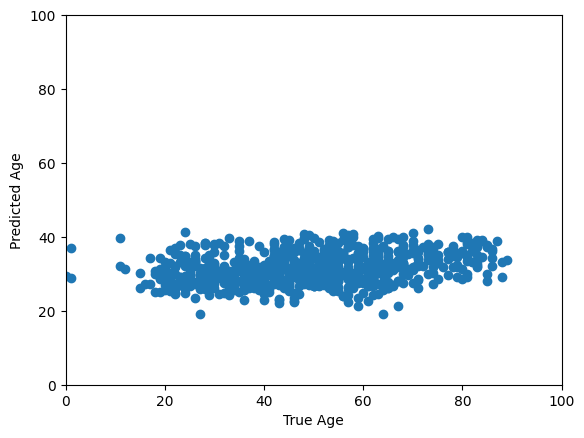

In [ ]:
# plot predicted age vs. true age
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
# set xmin and xmax to the same value to make the plot square
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

In [3]:
from sentence_transformers import SentenceTransformer

model = AutoModel.from_pretrained("hkunlp/instructor-xl")
tokenizer = AutoTokenizer.from_pretrained("hkunlp/instructor-xl")

Downloading: 100%|██████████| 1.52k/1.52k [00:00<00:00, 558kB/s]
Downloading: 100%|██████████| 4.96G/4.96G [01:45<00:00, 47.0MB/s]
Some weights of T5Model were not initialized from the model checkpoint at hkunlp/instructor-xl and are newly initialized: ['decoder.block.4.layer.2.layer_norm.weight', 'decoder.block.23.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.12.layer.1.EncDecAttention.k.weight', 'decoder.block.20.layer.2.DenseReluDense.wi.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.14.layer.0.SelfAttention.k.weight', 'decoder.block.9.layer.2.DenseReluDense.wi.weight', 'decoder.block.14.layer.1.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.21.layer.1.EncDecAttention.v.weight', 'decoder.bl

In [5]:
"""
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
"""
sentence = "sauce"
desc_tokenized = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
outputs = model.encoder(**desc_tokenized)
emb = outputs.to_tuple()[0][0][0].detach().numpy().tolist()


In [7]:
outputs

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 5.1890e-01,  1.2115e-01, -2.6725e-02,  ...,  7.7272e-02,
           5.0293e-01, -3.4116e-01],
         [ 7.1057e-02,  6.9810e-02, -4.7813e-02,  ...,  2.0375e-01,
           1.1002e-01, -6.0529e-02],
         [-1.2254e-01,  1.4338e-01,  9.5085e-02,  ...,  1.2603e-01,
           5.8572e-01, -1.9992e-01],
         ...,
         [-1.2521e-01,  1.0445e-01, -7.1089e-02,  ..., -2.5637e-04,
           3.1636e-01, -3.5995e-01],
         [-1.2521e-01,  1.0445e-01, -7.1089e-02,  ..., -2.5637e-04,
           3.1636e-01, -3.5995e-01],
         [-1.2521e-01,  1.0445e-01, -7.1089e-02,  ..., -2.5637e-04,
           3.1636e-01, -3.5995e-01]]], grad_fn=<MulBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)